In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_csv("user_growth.csv")


In [49]:
df

,year,month,week,total_customers,total_orders,agg_aov,total_campaigns,total_impressions,total_clicks,total_conversions,total_spend,total_revenue,num_apps,num_emails,num_smss,Social Media,roas
0,2023,3,11,21,198,1219.826667,27,169828,15068,1586,80695.52,172823.03,9,6,3,9,2.14
1,2023,3,12,31,379,1103.348765,63,340251,35455,3757,197122.33,373701.77,13,21,17,12,1.90
2,2023,3,13,22,229,1070.185660,45,231460,25405,2743,133515.46,254295.60,9,13,16,7,1.90
3,2023,4,13,9,82,1095.342963,18,108768,9852,931,60599.81,102264.01,7,3,3,5,1.69
4,2023,4,14,36,400,1140.620118,63,351381,34418,3678,194767.81,405625.46,13,14,17,19,2.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024,10,42,33,361,1050.838824,63,339399,37739,3603,180789.02,355748.22,16,14,16,17,1.97
99,2024,10,43,32,290,1137.433125,63,369738,33130,3204,191352.91,374875.43,16,15,16,16,1.96
100,2024,10,44,14,139,1185.816765,36,152418,19551,2074,92676.86,214216.38,12,13,11,0,2.31
101,2024,11,44,12,109,894.246897,27,167654,16606,1486,82122.99,156076.92,7,12,5,3,1.90


In [55]:

X = df.drop(columns=['total_customers','total_revenue','agg_aov' ,'total_orders'],axis=1)
y = df['total_customers']



In [56]:
import statsmodels.api as sm

# Add constant term for intercept
X_with_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Print detailed summary (includes t-stats and p-values)
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:        total_customers   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     17.83
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           6.31e-19
Time:                        18:01:52   Log-Likelihood:                -314.22
No. Observations:                 103   AIC:                             654.4
Df Residuals:                      90   BIC:                             688.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3927.5420   2487.23

In [61]:
X=df.copy()
X['cum_impressions'] = df['total_impressions'].cumsum()
X['cum_clicks'] = df['total_clicks'].cumsum()
X['cum_spend'] = df['total_spend'].cumsum()
X['cum_conversions'] = df['total_conversions'].cumsum()
X['cum_campaigns'] = df['total_campaigns'].cumsum()
X['cum_emails'] = df['num_emails'].cumsum()
X['cum_sms'] = df['num_smss'].cumsum()
X['cum_app'] = df['num_apps'].cumsum()
X['cum_social'] = df['Social Media'].cumsum()
X['cum_customers'] = df['total_customers'].cumsum()

In [62]:

X1 = X.drop(columns=['total_customers','total_revenue','agg_aov','cum_customers', 'total_impressions', 'total_clicks', 'total_spend',
    'total_conversions', 'total_campaigns', 'num_emails',
    'num_smss', 'num_apps', 'Social Media' ])
y = X['cum_customers']

In [63]:
import statsmodels.api as sm

# Add constant term for intercept
X_with_const = sm.add_constant(X1)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Print detailed summary (includes t-stats and p-values)
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          cum_customers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.633e+04
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.71e-153
Time:                        18:06:48   Log-Likelihood:                -401.28
No. Observations:                 103   AIC:                             830.6
Df Residuals:                      89   BIC:                             867.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.089e+06   1.07e+06     

In [158]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
X = df.drop(columns=['total_customers','total_revenue','agg_aov','total_orders' ,'week','month','year'])
y = df['total_customers']
X_y_combined=pd.concat([y,X],axis=1)


In [107]:
X_y_combined.shape

(103, 11)

In [108]:
def find_diff_order(df, max_diff=5):
    diff_orders = {}
    
    for col in df.columns.values[:]:
        temp_series = df[col]
        diff_count = 0
        
        while diff_count < max_diff:
            test_result = adfuller(temp_series.dropna(), autolag="AIC")
            if test_result[1] < 0.05:
                break
            temp_series = temp_series.diff()
            diff_count += 1
        
        diff_orders[col] = diff_count
    
    return diff_orders

In [109]:
diff_needed = find_diff_order(X_y_combined)
print(diff_needed)

{'total_customers': 0, 'total_campaigns': 0, 'total_impressions': 0, 'total_clicks': 1, 'total_conversions': 0, 'total_spend': 0, 'num_apps': 0, 'num_emails': 1, 'num_smss': 0, 'Social Media': 0, 'roas': 0}


In [110]:
 def grangers_causation_matrix(data, variables, max_lag=4, verbose=False):    
    df_lr = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df_chi2 = df_lr.copy()
    df_ftest = df_lr.copy()

    for col_x in variables:
        for col_y in variables:
            if col_x != col_y:  # Avoid self-causality tests
                try:
                    test_result = grangercausalitytests(data[[col_y, col_x]], max_lag, verbose=False)

                    # Extract p-values across all lags for different tests
                    lr_p_values = [test_result[lag][0]['lrtest'][1] for lag in test_result.keys()]
                    chi2_p_values = [test_result[lag][0]['ssr_chi2test'][1] for lag in test_result.keys()]
                    ftest_p_values = [test_result[lag][0]['params_ftest'][1] for lag in test_result.keys()]

                    # Store the minimum p-values
                    df_lr.loc[col_y, col_x] = min(lr_p_values)
                    df_chi2.loc[col_y, col_x] = min(chi2_p_values)
                    df_ftest.loc[col_y, col_x] = min(ftest_p_values)

                    if verbose:
                        print(f'Y = {col_y}, X = {col_x}, Min P-Values => LR: {df_lr.loc[col_y, col_x]}, Chi2: {df_chi2.loc[col_y, col_x]}, F-Test: {df_ftest.loc[col_y, col_x]}')

                except:
                    df_lr.loc[col_y, col_x] = None
                    df_chi2.loc[col_y, col_x] = None
                    df_ftest.loc[col_y, col_x] = None

    # Rename columns to indicate predictor-response relationship
    df_lr.columns = [var + '_x' for var in variables]
    df_lr.index = [var + '_y' for var in variables]
    df_chi2.columns = df_lr.columns
    df_chi2.index = df_lr.index
    df_ftest.columns = df_lr.columns
    df_ftest.index = df_lr.index

    return df_lr, df_chi2, df_ftest

In [125]:
variables = X_y_combined.diff().dropna().columns.tolist()
df_lr, df_chi2, df_ftest = grangers_causation_matrix(X_y_combined.diff().dropna(), variables, max_lag=20, verbose=False)

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

In [126]:
df_chi2

,total_customers_x,total_campaigns_x,total_impressions_x,total_clicks_x,total_conversions_x,total_spend_x,num_apps_x,num_emails_x,num_smss_x,Social Media_x,roas_x
total_customers_y,0.000000,4.137439e-08,1.692070e-07,7.092492e-12,1.393861e-07,9.206881e-08,1.998314e-05,1.345278e-01,2.476331e-06,3.781929e-02,0.001716
total_campaigns_y,0.007003,0.000000e+00,3.861927e-03,8.589689e-02,9.113516e-03,8.085694e-07,4.062186e-05,9.557666e-03,4.547989e-02,1.560323e-04,0.358418
total_impressions_y,0.027153,1.519513e-03,0.000000e+00,6.452119e-04,5.835118e-04,2.446093e-04,8.769338e-06,1.099324e-03,3.301672e-03,3.700943e-05,0.076484
total_clicks_y,0.002684,2.896036e-02,1.675801e-03,0.000000e+00,4.185338e-03,1.421489e-04,4.153177e-02,1.881980e-01,2.339693e-02,1.712805e-02,0.177486
total_conversions_y,0.010920,3.569500e-03,2.940049e-04,1.485829e-03,0.000000e+00,1.979253e-04,3.861128e-05,1.330948e-02,5.428760e-03,2.581847e-05,0.056795
total_spend_y,0.042639,2.522213e-06,1.702011e-02,3.248434e-03,9.203422e-05,0.000000e+00,2.550661e-07,2.087786e-02,4.170831e-02,5.735364e-04,0.199883
num_apps_y,0.001679,7.326303e-12,3.067272e-19,2.939740e-08,1.704234e-09,1.486677e-07,0.000000e+00,6.488655e-06,1.088341e-02,2.119190e-09,0.004426
num_emails_y,0.003247,8.793709e-08,1.982598e-12,3.137416e-09,5.016161e-10,2.082470e-08,3.839560e-05,0.000000e+00,1.136774e-06,1.920692e-06,0.350331
num_smss_y,0.004102,3.133060e-03,1.091289e-02,2.695949e-03,3.679492e-03,1.266598e-03,6.896131e-05,2.361749e-02,0.000000e+00,2.931078e-04,0.279746
Social Media_y,0.000167,5.711151e-14,1.194454e-10,3.256056e-10,2.069147e-13,3.726277e-15,8.164035e-07,1.854951e-15,2.146068e-07,0.000000e+00,0.032847


In [131]:
df_ftest

,total_customers_x,total_campaigns_x,total_impressions_x,total_clicks_x,total_conversions_x,total_spend_x,num_apps_x,num_emails_x,num_smss_x,Social Media_x,roas_x
total_customers_y,0.000000,0.000059,0.004921,0.000002,1.607439e-04,6.322641e-05,0.017561,0.415539,0.000146,0.116218,0.273584
total_campaigns_y,0.047904,0.000000,0.005392,0.183404,1.503075e-01,2.250355e-02,0.089844,0.201374,0.061456,0.149327,0.437839
total_impressions_y,0.352676,0.002350,0.000000,0.001288,2.996267e-02,1.129176e-02,0.050429,0.180625,0.061484,0.186456,0.394195
total_clicks_y,0.027090,0.305172,0.005064,0.000000,1.112446e-01,6.806485e-02,0.112104,0.209964,0.037234,0.272167,0.286443
total_conversions_y,0.075330,0.140368,0.015546,0.027262,0.000000e+00,1.906921e-02,0.112296,0.294881,0.096190,0.094490,0.384226
total_spend_y,0.299183,0.017859,0.028644,0.143219,1.343597e-02,0.000000e+00,0.068578,0.087385,0.161599,0.068624,0.427580
num_apps_y,0.393699,0.005920,0.000450,0.003696,1.483025e-02,2.007467e-02,0.000000,0.131456,0.027269,0.010502,0.106724
num_emails_y,0.026488,0.000573,0.000244,0.000248,1.919747e-03,9.565180e-04,0.077531,0.000000,0.000891,0.015794,0.454631
num_smss_y,0.142975,0.006362,0.016425,0.006138,1.147760e-02,1.870061e-02,0.017456,0.032339,0.000000,0.038005,0.289621
Social Media_y,0.009574,0.000002,0.000022,0.000006,7.312473e-07,8.380983e-07,0.000023,0.000098,0.007150,0.000000,0.295800


In [154]:
from statsmodels.tsa.api import VAR
final_data=X_y_combined.drop(['num_emails','roas'],axis=1)
train_size = int(0.8 * len(final_data))
train, test = final_data.iloc[:train_size], final_data.iloc[train_size:]
model = VAR(train)
lag_order = model.select_order(maxlags=7)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       77.93      78.21*   6.981e+33       78.04
1       78.90       81.68   1.872e+34       80.01
2       79.66       84.95   4.383e+34       81.77
3       80.04       87.83   8.113e+34       83.15
4       79.68       89.97   9.385e+34       83.79
5       79.14       91.93   1.444e+35       84.25
6       76.26       91.56   5.043e+34       82.37
7      67.35*       85.14  3.101e+32*      74.45*
-------------------------------------------------


In [155]:

optimal_lag = lag_order.aic  # You can change this to .bic if preferred

fitted_model = model.fit(optimal_lag)
print(fitted_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Apr, 2025
Time:                     20:53:24
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    85.1435
Nobs:                     75.0000    HQIC:                   74.4519
Log likelihood:          -2907.23    FPE:                3.10094e+32
AIC:                      67.3452    Det(Omega_mle):     1.20202e+30
--------------------------------------------------------------------
Results for equation total_customers
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       37.997372        30.039020            1.265           0.206
L1.total_customers           0.482863         0.427693            1.129           0.259
L1.total_campaigns    

In [156]:
forecast_steps = len(test)

# Forecast (on differenced or level data, depending on your case)
forecast = fitted_model.forecast(train.values[-optimal_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=train.columns)

# Compare actual vs predicted (for a variable, e.g., total_customers)
from sklearn.metrics import mean_absolute_percentage_error, r2_score

target = 'total_customers'
actual = test[target].values
predicted = forecast_df[target].values

# MAPE
mape = mean_absolute_percentage_error(actual, predicted) * 100
print(f"\n📉 MAPE on test set ({target}): {mape:.2f}%")

# R²
r2 = r2_score(actual, predicted)
print(f"🧮 R² on test set ({target}): {r2:.4f}")


📉 MAPE on test set (total_customers): 148.74%
🧮 R² on test set (total_customers): -2.4466


In [170]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X1=X.drop(['num_apps','num_emails','Social Media','num_smss','total_campaigns'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["feature"] = X1.columns
print(vif)

          VIF            feature
0  198.143282  total_impressions
1  226.975058       total_clicks
2  249.290357  total_conversions
3  338.614584        total_spend
4   10.264566               roas


In [19]:
feature_scores = []
for feature in X.columns:
    # Use only one column
    X_single = X[[feature]]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.2, random_state=42)
    
    # Train linear model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and calculate R²
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Save result
    feature_scores.append((feature, r2))

# Convert to DataFrame and sort by R²
single_feature_r2 = pd.DataFrame(feature_scores, columns=["Feature", "R2_Score"]).sort_values(by="R2_Score", ascending=False)

print(single_feature_r2)

            Feature  R2_Score
5        cum_clicks  0.999559
8     cum_campaigns  0.999429
11          cum_app  0.999398
6         cum_spend  0.999357
7   cum_conversions  0.999329
4   cum_impressions  0.999183
9        cum_emails  0.999172
10          cum_sms  0.998999
12       cum_social  0.998392
0              year  0.776666
2              week  0.020247
1             month  0.013719
3              roas -0.076583


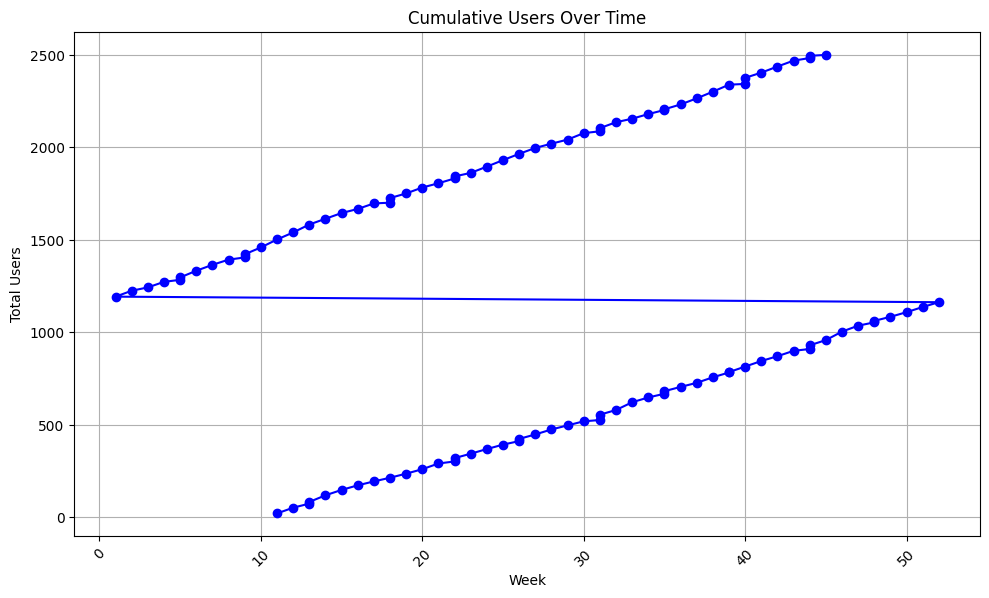

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['week'], df['cum_customers'], marker='o', color='blue')
plt.title('Cumulative Users Over Time')
plt.xlabel('Week')
plt.ylabel('Total Users')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()